In [1]:
%matplotlib inline
import os
import sys
import numpy as np
from astropy.io import fits as pf
from sklearn.neighbors import KernelDensity as kde
from scipy import integrate
import camb
from camb import model
from scipy.special import j0
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax3d
from skmonaco import mcquad
from skmonaco import mcmiser
import time

In [2]:
# Compute the matter power spectrum from CAMB and Generate the P(z,k) function to output the power at any given redshift
#and wavenumber

#First define Planck 2015 cosmological parameters
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons

#Tinker 2010 L1000W
#H = 70 #H0. 
#oc = 0.23 #physical density of CDM 
#ob = 0.04 #physical density of baryons

#Conversion to density param: Omega_Matter = (oc+ob)/(H0/100.)**2

#Set up parameters in CAMB
pars = camb.CAMBparams()
#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
#pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 

#Hard code the cosmolgy params
pars.H0=H #hubble param (No h!!)
pars.omegab=ob #Baryon density parameter
pars.omegac=oc #CDM density parameter
pars.omegav=0.725 #Vacuum density parameter
pars.set_dark_energy()

#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#ns is scalar spectral index
pars.InitPower.set_params(ns=0.960)
camb.set_halofit_version(version='original') #uses the Smith 2003 halo model
ze=np.linspace(0,20,150)
ka=np.logspace(-4,1,len(ze))#np.linspace(0,10,100)
#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#pars: input parameters, zs: redshift range, nonlinear: generate nonlinear power spectrum, hubble_units=True: output as Mpc/h^3 
#instead of Mpc^3, k_hunit if true, matter power is a function of k/h, if false, just k (both Mpc^{-1} units)
PK = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=True, hubble_units=True, k_hunit=True, kmax = ka[-1])
PK2 = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=True, hubble_units=True, k_hunit=False, kmax = ka[-1])
PK3 = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=True, hubble_units=False, k_hunit=True, kmax = ka[-1])
PK4 = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=True, hubble_units=False, k_hunit=False, kmax = ka[-1])

#Generate the power using the interpolator and the z and k arrays
#Power = PK.P(z,k)

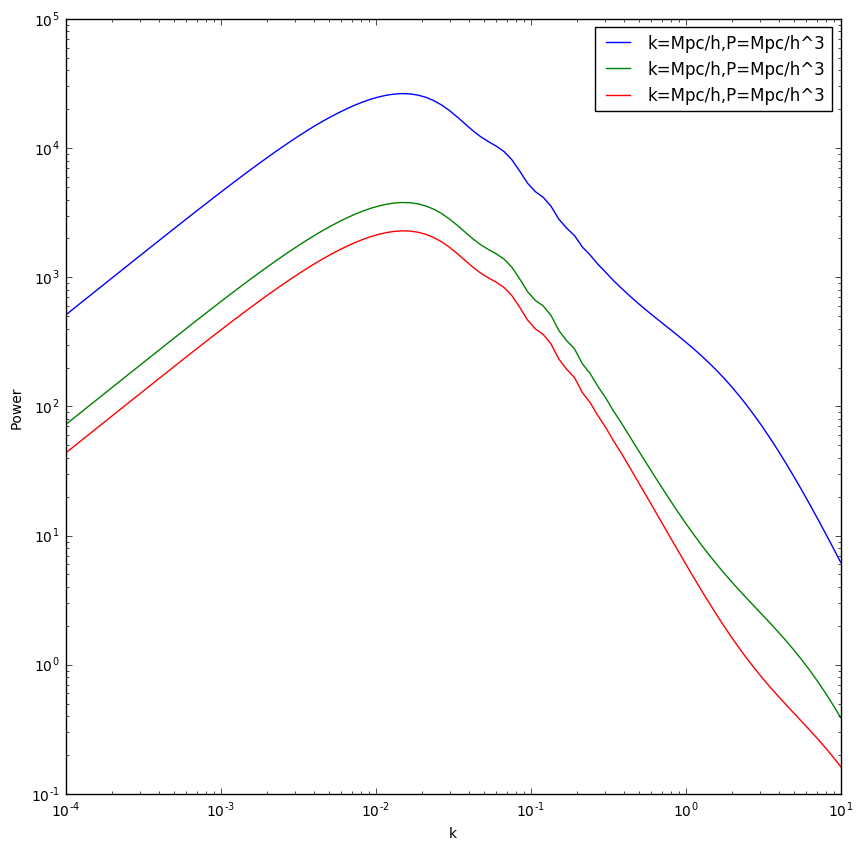

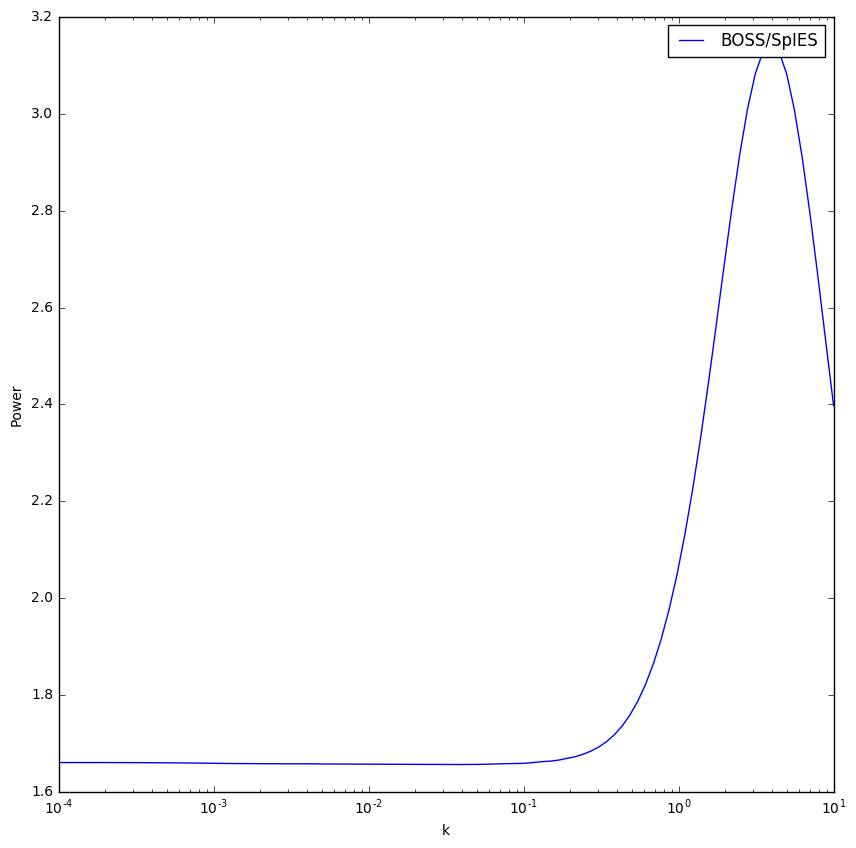

In [3]:
k = np.logspace(-4,1,100)

plt.figure(1, figsize = (10,10))
plt.plot(k,PK.P(0,k),label='k=Mpc/h,P=Mpc/h^3')
plt.plot(k,PK.P(2.434,k),label='k=Mpc/h,P=Mpc/h^3')
plt.plot(k,PK.P(3.45,k),label='k=Mpc/h,P=Mpc/h^3')


#plt.plot(k,PK2.P(0,k),label='k=Mpc,P=Mpc/h^3')
#plt.plot(k,PK3.P(0,k),label='k=Mpc/h,P=Mpc^3')
#plt.plot(k,PK4.P(0,k),label='k=Mpc,P=Mpc^3')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Power')
plt.legend()
plt.show()

plt.figure(9, figsize = (10,10))
plt.plot(k,PK.P(2.434,k)/PK.P(3.45,k),label='BOSS/SpIES')

plt.xscale('log')
plt.xlabel('k')
plt.ylabel('Power')
plt.legend()
plt.show()

In [4]:
def dimpower1(Pk,z,k):
    delta = Pk.P(z,k/0.7) * k**3/(2*np.pi**2)
    return delta

def dimpower4(Pk,z,k):
    delta = Pk.P(z,k) * k**3/(2*np.pi**2)
    return delta

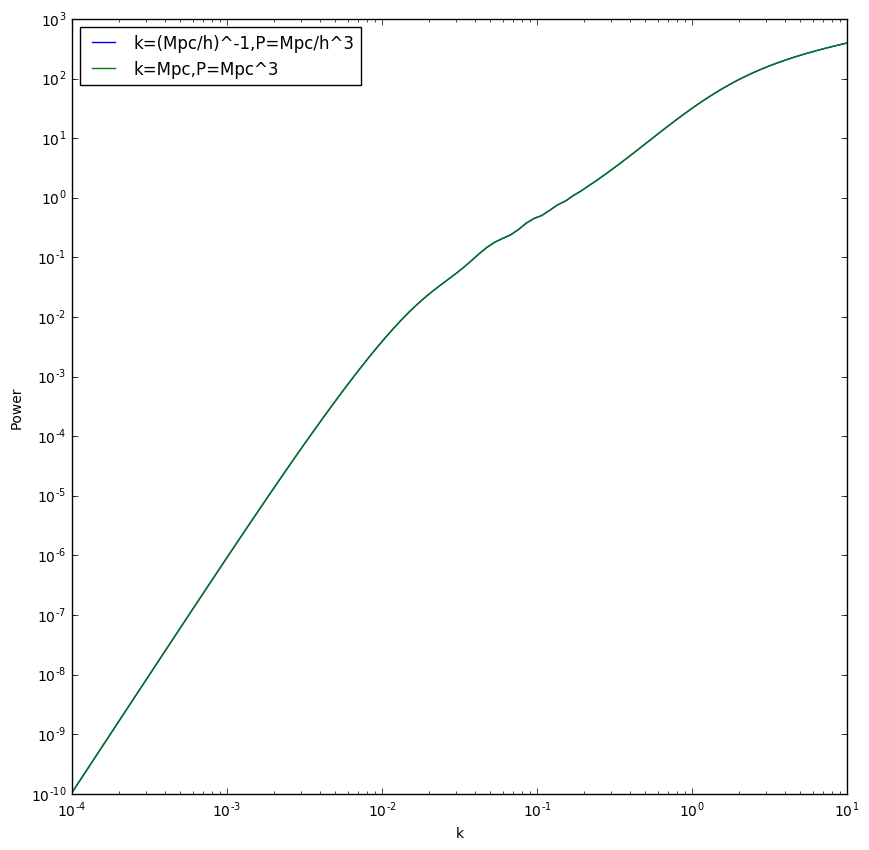

In [5]:
k = np.logspace(-4,1,100)

plt.figure(1, figsize = (10,10))
plt.plot(k,dimpower1(PK,0,k)/0.7**3,label='k=(Mpc/h)^-1,P=Mpc/h^3')
#plt.plot(k,dimpower(PK2,0,k)/0.7**3,label='k=Mpc,P=Mpc/h^3')
#plt.plot(k*0.7,dimpower(PK3,0,k)*0.7**3,label='k=Mpc/h,P=Mpc^3')
plt.plot(k,dimpower4(PK4,0,k),label='k=Mpc,P=Mpc^3')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Power')
plt.legend(loc=2)
plt.show()

In [4]:
def dimpower(Pk,z,k):
    delta = Pk.P(z,k) * k**3/(2*np.pi**2)
    return delta
    
def domega(kz,theta,cambpars,H0,dndz,Power,OmegaM,OmegaL,evalint=False):
    if evalint == True:
    	#Use this if integrating ln(10)k dlog(k)
    	#start = time.time()
        k=kz[0]
        z=kz[1]
        bkg = camb.get_background(cambpars)
        x = 10**k * (theta/60./180.*np.pi) * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * 10**(-k) * dimpower(Power,z,10**k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5*np.log(10)
        #end = time.time()
        #print end-start
        ## USe this if integrating dk 
        #x = k * theta * bkg.comoving_radial_distance(z)
        #om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    if evalint == False:
        #project the z array onto new axis to output a matrix when evaluating in k and z. This allows
        #me to plot a wireframe 3d plot
        #k=kz[0]
        #z=kz[1]
        z = np.array(z) 
        z = z[:,np.newaxis]
        bkg = camb.get_background(cambpars)
        x = k * theta * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    
    return om
#Import SpIES / SHELA data
data = '../Data_Sets/QSO_Candidates_allcuts_with_errors_visualinsp.fits'
obs = pf.open(data)[1].data
Z = obs.zphotNW
gdx = ((Z >= 3.4)&(Z <= 5.12)&(obs.Good_obj ==0))
#gdx = Z>0
#Set up a KDE for dNdz
tmpz = Z[gdx][:, np.newaxis] #change the array from row shape (1) to column shape (1,)
print np.shape(tmpz)
sample_range = np.linspace(min(tmpz[:, 0]), max(tmpz[:, 0]), len(tmpz[:, 0]))[:, np.newaxis]
est = kde(bandwidth=0.1,kernel='gaussian') #Set up the Kernel
histkde = est.fit(tmpz).score_samples(sample_range) #fit the kernel to the data and find the density of the grid
#Interpolate (you get the same function back) to plug in any z in the range (as opposed to set z values)
dNdz = interpolate.interp1d(sample_range.flatten(),np.exp(histkde))
print sample_range.flatten()
print 'done'
ZE = np.linspace(min(Z),max(Z),100)
xo=integrate.quad(dNdz,min(sample_range),max(sample_range)) #quad(f(x),xlower,xupper, args)
print xo

(4482, 1)
[ 3.40006029  3.40044189  3.40082349 ...,  5.10923694  5.10961854
  5.11000013]
done
(0.943364385394657, 1.0143834106024485e-08)


In [47]:
# For hunit = True and khunit = true
def dimpower(Pk,z,k):
    delta = Pk.P(z,k/0.7) * k**3/(2*np.pi**2)
    return delta
    
def domega(kz,theta,cambpars,H0,dndz,Power,OmegaM,OmegaL,evalint=False):
    if evalint == True:
    	#Use this if integrating ln(10)k dlog(k)
    	#start = time.time()
        k=kz[0]
        z=kz[1]
        bkg = camb.get_background(cambpars)
        x = 10**(k) * (theta/60./180.*np.pi) * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * 10**(-k) * dimpower(Power,z,10**(k)) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5*np.log(10)
        #end = time.time()
        #print end-start
        ## USe this if integrating dk 
        #x = k * theta * bkg.comoving_radial_distance(z)
        #om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    if evalint == False:
        #project the z array onto new axis to output a matrix when evaluating in k and z. This allows
        #me to plot a wireframe 3d plot
        #k=kz[0]
        #z=kz[1]
        z = np.array(z) 
        z = z[:,np.newaxis]
        bkg = camb.get_background(cambpars)
        x = k * theta * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    
    return om
#Integrate using mcmiser

omegaM = (oc+ob)#/(H/100.)**2
omegaL= 1.0-omegaM

print H,omegaM, omegaL, omegaM+omegaL
print 'begin integration'    
s= time.time()
#mcquad(fn,integrand xl=[0.,0.],xu=[1.,1.], lower and upper limits of integration npoints=100000  number of points,args)
newtheta = np.logspace(-1.3,2.5,20)
mclimber = []
for i in range(len(newtheta)):
	thetas = newtheta[i]
	test = mcmiser(domega, xl=[-3.0,3.41], xu=[2.0,5.1], npoints=1e3, args=(thetas,pars,H,dNdz,PK,omegaM,omegaL,True))
	mclimber.append(test[0])
print mclimber
e=time.time()

print e-s


70 0.275 0.725 1.0
begin integration
[0.00071679924250264129, 0.0011754579693858496, 0.00090665209032480024, 0.00087835981462780325, 0.00069537915167692458, 0.00053782776120054536, 0.00046979623997021224, 0.00036977238786827665, 0.00025391659675613097, 0.00023821005071832988, 0.00017234137685498161, 0.00018768056071799167, 3.6778600334667739e-05, -8.8666977205395637e-07, 6.7911537698124526e-06, 1.7317018682244042e-05, 9.2226224782701307e-06, 6.6937715219930493e-06, -1.1778039379301605e-07, -5.8883609513679841e-07]
202.278024912


In [ ]:
# For hunit = true and khunit = false
def dimpower(Pk,z,k):
    delta = Pk.P(z,k) * k**3/(2*np.pi**2)
    return delta
    
def domega(kz,theta,cambpars,H0,dndz,Power,OmegaM,OmegaL,evalint=False):
    if evalint == True:
    	#Use this if integrating ln(10)k dlog(k)
    	#start = time.time()
        k=kz[0]
        z=kz[1]
        bkg = camb.get_background(cambpars)
        x = 10**(k) * (theta/60./180.*np.pi) * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * 10**(-k) * dimpower(Power,z,10**(k)) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5*np.log(10)
        #end = time.time()
        #print end-start
        ## USe this if integrating dk 
        #x = k * theta * bkg.comoving_radial_distance(z)
        #om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    if evalint == False:
        #project the z array onto new axis to output a matrix when evaluating in k and z. This allows
        #me to plot a wireframe 3d plot
        #k=kz[0]
        #z=kz[1]
        z = np.array(z) 
        z = z[:,np.newaxis]
        bkg = camb.get_background(cambpars)
        x = k * theta * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    
    return om
#Integrate using mcmiser

omegaM = (oc+ob)#/(H/100.)**2
omegaL= 1.0-omegaM

print H,omegaM, omegaL, omegaM+omegaL
print 'begin integration'    
s= time.time()
#mcquad(fn,integrand xl=[0.,0.],xu=[1.,1.], lower and upper limits of integration npoints=100000  number of points,args)
newtheta = np.logspace(-1.3,2.5,20)
mclimber2 = []
for i in range(len(newtheta)):
	thetas = newtheta[i]
	test = mcmiser(domega, xl=[-3.0,3.41], xu=[2.0,5.1], npoints=1e3, args=(thetas,pars,H,dNdz,PK2,omegaM,omegaL,True))
	mclimber2.append(test[0])
print mclimber2
e=time.time()

print e-s


70 0.275 0.725 1.0
begin integration


In [ ]:
# For hunit = false and khunit = true
def dimpower(Pk,z,k):
    delta = Pk.P(z,k/0.7) * k**3/(2*np.pi**2)
    return delta
    
def domega(kz,theta,cambpars,H0,dndz,Power,OmegaM,OmegaL,evalint=False):
    if evalint == True:
    	#Use this if integrating ln(10)k dlog(k)
    	#start = time.time()
        k=kz[0]
        z=kz[1]
        bkg = camb.get_background(cambpars)
        x = 10**k * (theta/60./180.*np.pi) * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * 10**(-k) * dimpower(Power,z,10**(k)) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5*np.log(10)
        #end = time.time()
        #print end-start
        ## USe this if integrating dk 
        #x = k * theta * bkg.comoving_radial_distance(z)
        #om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    if evalint == False:
        #project the z array onto new axis to output a matrix when evaluating in k and z. This allows
        #me to plot a wireframe 3d plot
        #k=kz[0]
        #z=kz[1]
        z = np.array(z) 
        z = z[:,np.newaxis]
        bkg = camb.get_background(cambpars)
        x = k * theta * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    
    return om
#Integrate using mcmiser

omegaM = (oc+ob)#/(H/100.)**2
omegaL= 1.0-omegaM

print H,omegaM, omegaL, omegaM+omegaL
print 'begin integration'    
s= time.time()
#mcquad(fn,integrand xl=[0.,0.],xu=[1.,1.], lower and upper limits of integration npoints=100000  number of points,args)
newtheta = np.logspace(-1.3,2.5,20)
mclimber3 = []
for i in range(len(newtheta)):
	thetas = newtheta[i]
	test = mcmiser(domega, xl=[-3.0,3.41], xu=[2.0,5.1], npoints=1e3, args=(thetas,pars,H,dNdz,PK3,omegaM,omegaL,True))
	mclimber3.append(test[0])
print mclimber3
e=time.time()

print e-s


In [10]:
# For hunit = false and khunit = false
def dimpower(Pk,z,k):
    delta = Pk.P(z,k) * k**3/(2*np.pi**2)
    return delta
    
def domega(kz,theta,cambpars,H0,dndz,Power,OmegaM,OmegaL,evalint=False):
    if evalint == True:
    	#Use this if integrating ln(10)k dlog(k)
    	#start = time.time()
        k=kz[0]
        z=kz[1]
        bkg = camb.get_background(cambpars)
        x = 10**k * (theta/60./180.*np.pi) * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * 10**(-k) * dimpower(Power,z,10**k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5*np.log(10)
        #end = time.time()
        #print end-start
        ## USe this if integrating dk 
        #x = k * theta * bkg.comoving_radial_distance(z)
        #om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    if evalint == False:
        #project the z array onto new axis to output a matrix when evaluating in k and z. This allows
        #me to plot a wireframe 3d plot
        #k=kz[0]
        #z=kz[1]
        z = np.array(z) 
        z = z[:,np.newaxis]
        bkg = camb.get_background(cambpars)
        x = k * theta * bkg.comoving_radial_distance(z)
        om = (H0/3.0e5) * k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    
    return om
#Integrate using mcmiser

omegaM = (oc+ob)#/(H/100.)**2
omegaL= 1.0-omegaM

print H,omegaM, omegaL, omegaM+omegaL
print 'begin integration'    
s= time.time()
#mcquad(fn,integrand xl=[0.,0.],xu=[1.,1.], lower and upper limits of integration npoints=100000  number of points,args)
newtheta = np.logspace(-1.3,2.5,20)
mclimber4 = []
for i in range(len(newtheta)):
	thetas = newtheta[i]
	test = mcmiser(domega, xl=[-3.0,3.41], xu=[2.0,5.1], npoints=1e3, args=(thetas,pars,H,dNdz,PK4,omegaM,omegaL,True))
	mclimber4.append(test[0])
print mclimber4
e=time.time()

print e-s


70 0.275 0.725 1.0
begin integration
[0.0021312455440256066, 0.0039175318401956875, 0.0021067738188587613, 0.0019272177397268028, 0.0018246395324642392, 0.0019823821762072983, 0.00090721726224878777, 0.0011777020176387122, 0.00078524080611577687, 0.00072809443353112873, 0.00074145266194710962, 0.00035201979659744856, 0.00032469820738151431, 9.6128117878994433e-05, 8.8620722614367935e-05, 2.3185776264910623e-05, -4.4713296397691063e-05, -4.7660885995050364e-06, -1.4210849908173122e-05, -1.5515727477105882e-05]
226.295502901


In [ ]:
print np.asarray(mclimber)/0.7**3
print np.asarray(mclimber2)/0.7**3
print np.asarray(mclimber3)
print np.asarray(mclimber4)

In [ ]:
newtheta = np.logspace(-1.3,2.5,20)
plt.figure(2,figsize = (10,10))
plt.plot(newtheta,np.asarray(mclimber)/0.7**3,label = '1')
plt.plot(newtheta,np.asarray(mclimber2)/0.7**3,label = '2')
plt.plot(newtheta,np.asarray(mclimber3),label = '3')
plt.plot(newtheta,np.asarray(mclimber4),label = '4')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()